# PGD Attack with TensorBoard Tracking

In this notebook, we will demonstrate how to use SecML-Torch to perform a Projected Gradient Descent (PGD) attack while tracking various metrics using TensorBoard integration.

We will:
- Load visualization utilities and dependencies
- Load the CIFAR-10 dataset and a pre-trained robust model
- Configure a PGD attack with multiple tracking capabilities
- Visualize the attack results and tracked metrics using TensorBoard

#### Import dependencies and load utils functions

In [43]:
%%capture --no-stderr
try:
    import secmlt
except ImportError:
    %pip install git+https://github.com/pralab/secml-torch

try:
    import tensorboard
except ImportError:
    %pip install tensorboard

try:
    import robustbench
except ImportError:
    %pip install robustbench

In [44]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# SecML-Torch imports
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.metrics.classification import Accuracy
from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
from secmlt.adv.backends import Backends

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# CIFAR-10 class names
cifar10_classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


def convert_cifar_image(image):
    """Convert tensor image to numpy format for matplotlib display."""
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    if image.ndim == 3:
        image = image.transpose((1, 2, 0))  # CHW to HWC
    # Ensure values are in [0, 1] range for display
    image = np.clip(image, 0, 1)
    return image


def show_adversarial_comparison(
    clean_samples,
    adv_samples,
    clean_labels,
    adv_preds,
    title="Clean vs Adversarial Examples",
    n_display=5,
):
    """Show comparison between clean and adversarial examples."""
    n_display = min(n_display, len(clean_samples))
    fig, axes = plt.subplots(3, n_display, figsize=(2.5 * n_display, 8))

    fig.suptitle(title, fontsize=14)

    for idx in range(n_display):
        # Clean image
        clean_img = convert_cifar_image(clean_samples[idx])
        axes[0, idx].imshow(clean_img)
        if idx == 0:
            axes[0, idx].set_ylabel("Clean", fontsize=12)
        axes[0, idx].set_title(
            f"True: {cifar10_classes[clean_labels[idx]]} ({clean_labels[idx]})",
            fontsize=10,
        )
        axes[0, idx].axis("off")

        # Adversarial image
        adv_img = convert_cifar_image(adv_samples[idx])
        axes[1, idx].imshow(adv_img)
        if idx == 0:
            axes[1, idx].set_ylabel("Adversarial", fontsize=12)
        color = "green" if clean_labels[idx] == adv_preds[idx] else "red"
        axes[1, idx].set_title(
            f"Pred: {cifar10_classes[adv_preds[idx]]} ({adv_preds[idx]})",
            color=color,
            fontsize=10,
        )
        axes[1, idx].axis("off")

        # Perturbation (scaled for visibility)
        perturbation = adv_samples[idx] - clean_samples[idx]
        perturbation = perturbation * 100
        pert_img = convert_cifar_image(perturbation)
        axes[2, idx].imshow(pert_img)
        if idx == 0:
            axes[2, idx].set_ylabel("Perturbation", fontsize=12)

        # Calculate L∞ norm
        linf_norm = torch.norm(perturbation.view(-1), p=float("inf")).item()
        axes[2, idx].set_title(f"L∞: {linf_norm:.4f} (Magnified)", fontsize=10)
        axes[2, idx].axis("off")

    plt.tight_layout()
    plt.show()

#### Set device and paths

In [45]:
# Setup device and paths
device = "mps"
dataset_path = "data/datasets/"
logs_path = "data/logs/pgd_tutorial"

# Create directories if they don't exist
Path(dataset_path).mkdir(parents=True, exist_ok=True)
Path(logs_path).mkdir(parents=True, exist_ok=True)

print(f"Using device: {device}")
print(f"Dataset path: {dataset_path}")
print(f"Logs will be saved to: {logs_path}")

Using device: mps
Dataset path: data/datasets/
Logs will be saved to: data/logs/pgd_tutorial


#### Loading CIFAR-10 Dataset

We'll load the CIFAR-10 dataset and use a small subset for demonstration.

In [46]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])

test_dataset = torchvision.datasets.CIFAR10(
    root=dataset_path, train=False, download=True, transform=transform
)

num_samples = 20
batch_size = num_samples // 2
test_subset = Subset(test_dataset, list(range(num_samples)))
test_data_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print(f"Loaded {len(test_subset)} samples from CIFAR-10 test set")

Files already downloaded and verified
Loaded 20 samples from CIFAR-10 test set


#### Loading a Pre-trained Robust Model

We'll load a robust model from RobustBench that has been trained to withstand adversarial attacks.

In [47]:
from robustbench.utils import load_model

# Load a robust model from RobustBench
net = load_model(
    model_name="Rade2021Helper_R18_ddpm", dataset="cifar10", threat_model="Linf"
)
net = net.to(device)
net.eval()

# Wrap the model with SecML-Torch's BasePytorchClassifier
model = BasePytorchClassifier(net)

print(f"Loaded robust model: Rade2021Helper_R18_ddpm")

Loaded robust model: Rade2021Helper_R18_ddpm


#### Baseline Performance Evaluation

Let's evaluate the model's performance on clean images.

In [48]:
# Test accuracy on clean examples
clean_accuracy = Accuracy()(model, test_data_loader)
print(
    f"Clean accuracy: {clean_accuracy.item():.4f} ({clean_accuracy.item() * 100:.2f}%)"
)

Clean accuracy: 0.9500 (95.00%)


#### Configuring PGD Attack with Tracking

Now we'll set up the PGD attack with comprehensive tracking capabilities.

In [49]:
# Import tracking components
from secmlt.trackers import (
    LossTracker,
    PredictionTracker,
    PerturbationNormTracker,
    GradientNormTracker,
    TensorboardTracker,
)

print("Tracking components imported successfully")

Tracking components imported successfully


In [50]:
# Configure PGD attack parameters
epsilon = 8 / 255       # Maximum L∞ perturbation
num_steps = 20          # Number of PGD iterations
step_size = 4 / 255     # Step size per iteration
perturbation_model = LpPerturbationModels.LINF  # L∞ norm constraint

print(f"Attack configuration:")
print(f"  - Epsilon: {epsilon:.4f} ({epsilon * 255:.1f}/255)")
print(f"  - Number of steps: {num_steps}")
print(f"  - Step size: {step_size:.4f} ({step_size * 255:.1f}/255)")

Attack configuration:
  - Epsilon: 0.0314 (8.0/255)
  - Number of steps: 20
  - Step size: 0.0157 (4.0/255)


In [51]:
# Set up individual trackers
trackers = [
    LossTracker(),
    PredictionTracker(),
    PerturbationNormTracker("linf"),
    GradientNormTracker(),
]

# Set up TensorBoard tracking
tensorboard_tracker = TensorboardTracker(logs_path, trackers)

print(f"Configured {len(trackers)} trackers with TensorBoard logging")
print(f"TensorBoard logs cleared and will be saved to: {logs_path}")

Configured 4 trackers with TensorBoard logging
TensorBoard logs cleared and will be saved to: data/logs/pgd_tutorial


#### Executing the PGD Attack with Tracking

Now we'll create the PGD attack and execute it with tracking enabled.

In [52]:
# Create PGD attack with tracking
pgd_attack = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    random_start=False,
    backend=Backends.NATIVE,
    trackers=tensorboard_tracker,
)

print("PGD attack configured successfully")

PGD attack configured successfully


In [53]:
# Execute the attack
print("Executing PGD attack with tracking...")
pgd_native_adv_ds = pgd_attack(model, test_data_loader)
print("Attack completed!")

Executing PGD attack with tracking...
Attack completed!


#### Results Analysis

Let's analyze the results of our PGD attack.

In [54]:
# Test accuracy on adversarial examples
adversarial_accuracy = Accuracy()(model, pgd_native_adv_ds)

print("=== Attack Results ===")
print(
    f"Clean accuracy:        {clean_accuracy.item():.4f} ({clean_accuracy.item() * 100:.2f}%)"
)
print(
    f"Adversarial accuracy:  {adversarial_accuracy.item():.4f} ({adversarial_accuracy.item() * 100:.2f}%)"
)
print(
    f"Attack success rate:   {1 - adversarial_accuracy.item():.4f} ({(1 - adversarial_accuracy.item()) * 100:.2f}%)"
)

=== Attack Results ===
Clean accuracy:        0.9500 (95.00%)
Adversarial accuracy:  0.6500 (65.00%)
Attack success rate:   0.3500 (35.00%)


Clean vs adversarial examples (the perturbation is amplified):


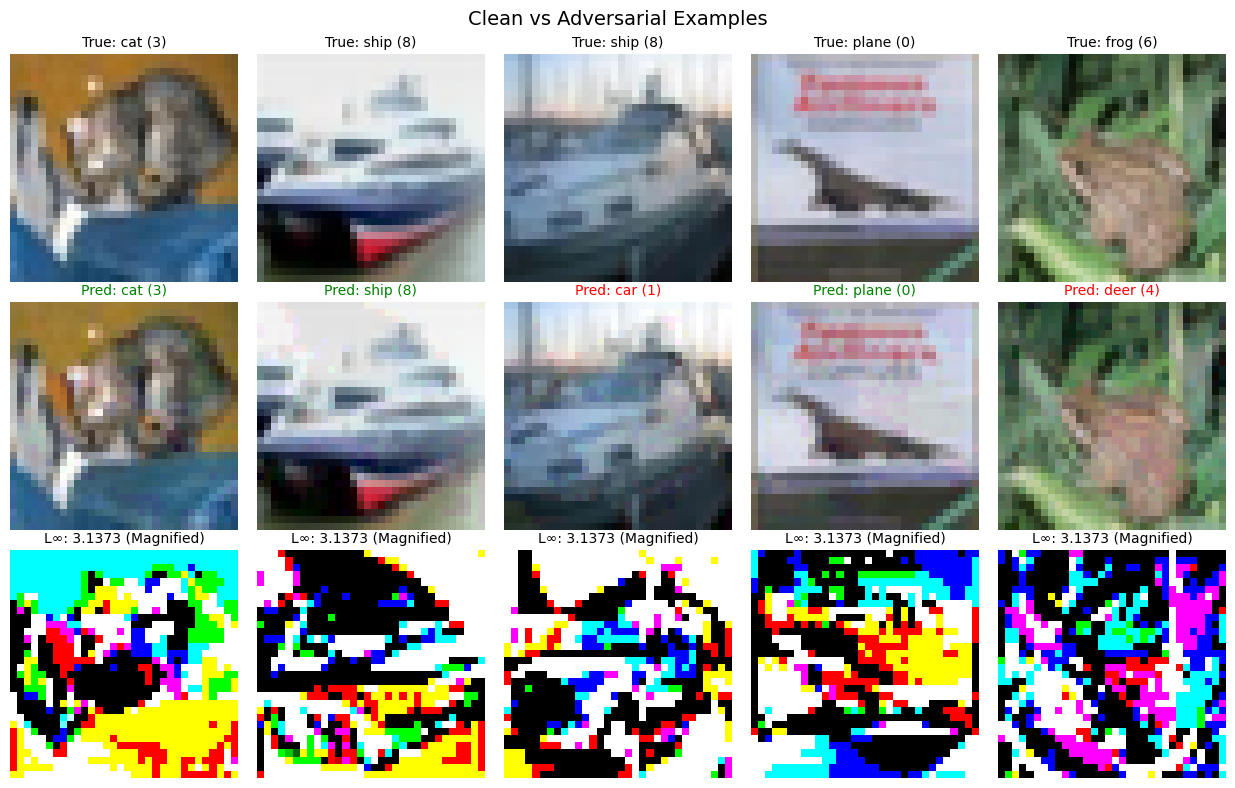

In [55]:
# Visualize clean vs adversarial examples
print("Clean vs adversarial examples (the perturbation is amplified):")

# Get samples for visualization
clean_iter = iter(test_data_loader)
clean_images, clean_labels = next(clean_iter)

adv_iter = iter(pgd_native_adv_ds)
adv_images, adv_labels = next(adv_iter)

# Get predictions
clean_preds = model.predict(clean_images.to(device))
adv_preds = model.predict(adv_images.to(device))

# Show comparison
show_adversarial_comparison(
    clean_images,
    adv_images,
    clean_labels,
    adv_preds,
    title="Clean vs Adversarial Examples",
)

#### TensorBoard Visualization

Now let's launch TensorBoard to see all the tracked metrics in detail. TensorBoard provides the most comprehensive view of the attack progression with interactive plots.

In [56]:
# Launch TensorBoard inline
print(
    "🚀 TensorBoard: http://localhost:6007 (open in your browser if not shown inline)\n"
)

# Uncomment this for inline visualization
# %load_ext tensorboard
# %tensorboard --logdir $logs_path --port 6007 --reload_interval 2

🚀 TensorBoard: http://localhost:6007 (open in your browser if not shown inline)



![04-pgd-tensorboard-tracking.png](../_static/assets/tutorials/04-pgd-tensorboard-tracking.png)
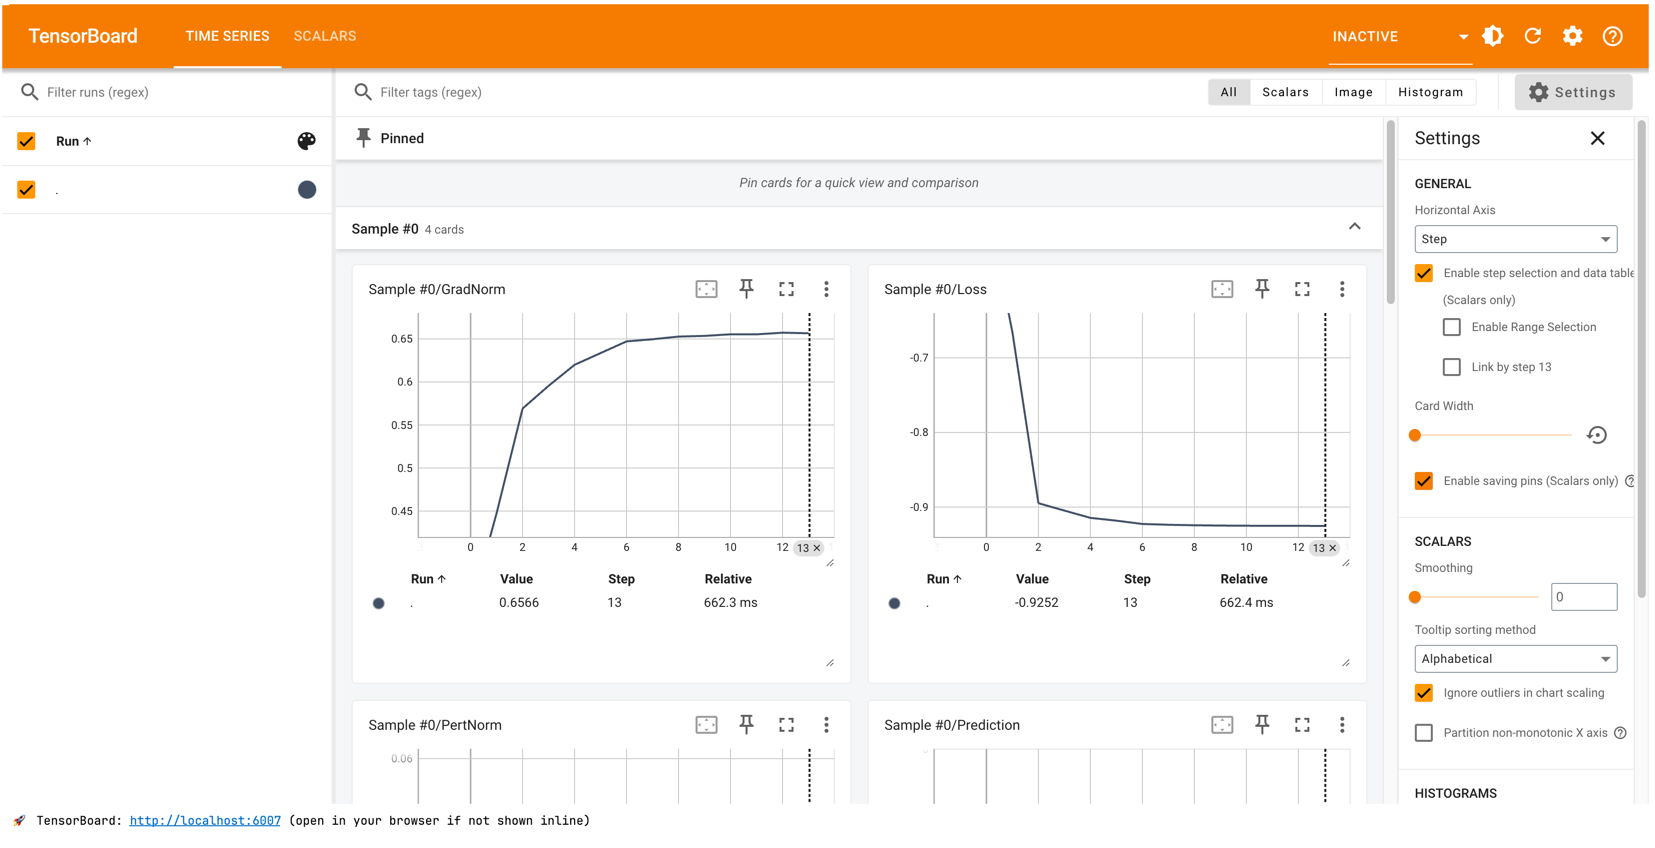